In [1]:
import os
import SimpleITK as stk
import copy
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from segment_anything import sam_model_registry
from skimage import transform
import cv2
from ipywidgets import interact, widgets

In [2]:
path_to_aires_ganglionnaires = '/Users/fcremone/dev/research/ontology-olivier/aires-ganglionnaires/Dicom_RT_and_Images_to_Mask/Examples/nifti/'
file_list = os.listdir(path_to_aires_ganglionnaires)

In [3]:
data_list = [x for x in file_list if 'Data' in x]
mask_list = [x for x in file_list if 'mask' in x]

In [4]:
def datafilename2maskfilename(fname):
    maskname = copy.copy(fname)
    maskname = maskname.replace('Data', 'mask')
    pat_id = fname.split('_')[-1].split('.')[0]
    maskname = '_'.join(maskname.split('_')[:-1])
    maskname += f'_y{pat_id}.nii.gz'
    return maskname

In [5]:
class RpaDataset(Dataset):
    def __init__(self, root_path, data_list, window, level):
        self.root_path = root_path
        self.data_list = data_list
        self.l = level
        self.w = window

    def __getitem__(self, index):
        filename = os.path.join(self.root_path, self.data_list[index])
        img = stk.ReadImage(filename)
        img = torch.permute(torch.tensor(stk.GetArrayFromImage(img)), (1,2,0))
        img = torch.clip((img - self.l + 0.5*self.w)/self.w, 0, 1)
        filename = os.path.join(self.root_path, datafilename2maskfilename(self.data_list[index]))
        mask = stk.ReadImage(filename)
        mask = torch.permute(torch.tensor(stk.GetArrayFromImage(mask)), (1,2,0))
        return img, mask

In [6]:
rpadata = RpaDataset(path_to_aires_ganglionnaires, data_list, window=350, level=40)

In [7]:
img, mask = rpadata[0]

In [8]:
num2levelname = {
     1: 'level_ia_left',
     2: 'level_ia_right',
     3: 'level_ib_left',
     4: 'level_ib_right',
     5: 'level_ii_left',
     6: 'level_ii_right',
     7: 'level_iii_left',
     8: 'level_iii_right',
     9: 'level_iv_left',
    10: 'level_iv_right',
    11: 'level_v_left',
    12: 'level_v_right',
    13: 'level_rp_left',
    14: 'level_rp_right',
}
levelname2num = {val: key for key, val in num2levelname.items()}

In [11]:
prompt_slice = 53
level = 'level_iii_left'
levelnum = levelname2num[level]
binmask = (mask[:,:,prompt_slice] == levelnum).to(torch.uint8)

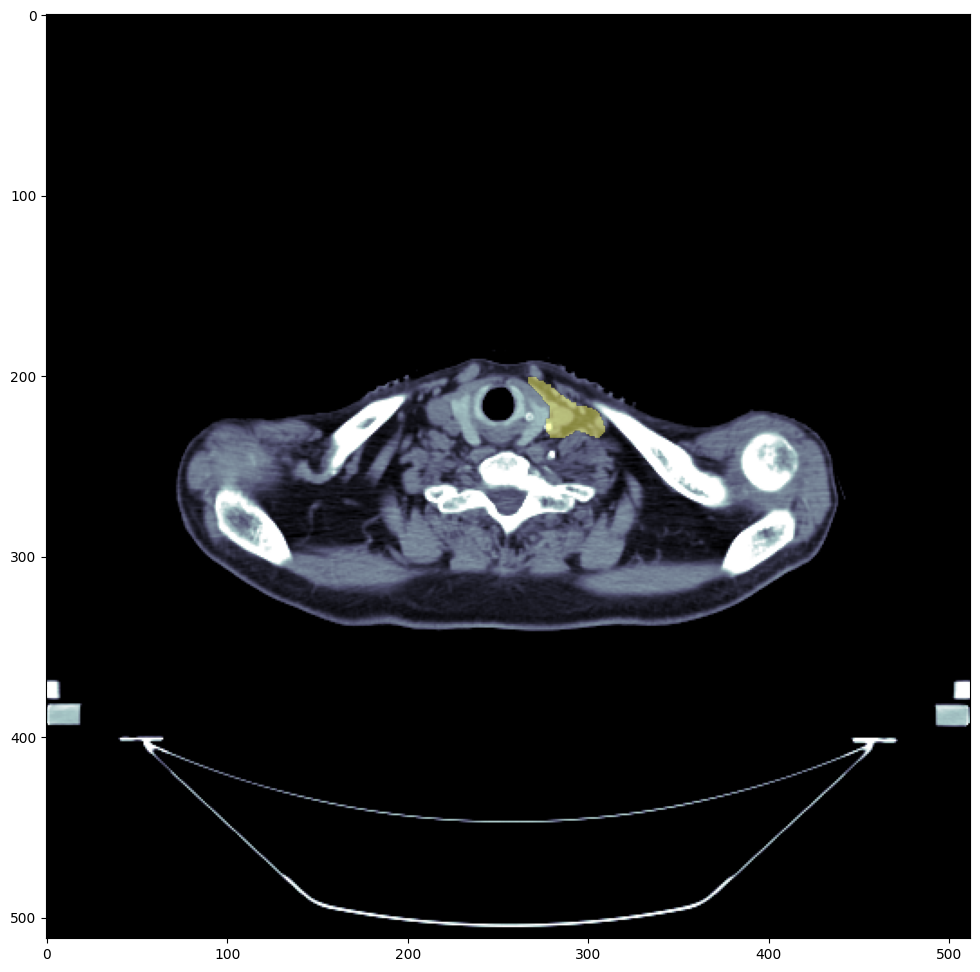

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img[..., prompt_slice], cmap='bone')
ax.imshow(np.ma.masked_where(binmask < 0.5, binmask), cmap='summer', vmin=0., vmax=1, alpha=0.5)

## Model

In [13]:
from transformers import SegGptImageProcessor, SegGptForImageSegmentation

In [14]:
model_id = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(model_id)
model = SegGptForImageSegmentation.from_pretrained(model_id)

## Inference on trained model

In [15]:
from PIL import Image

In [16]:
def to_png(x, convert_label=False):
    tensor = x.clone().detach()
    tensor = (tensor - tensor.min())/(tensor.max() - tensor.min())
    np_img = (tensor * 255).numpy().astype(np.uint8)

    #np_img = tensor.numpy()
    rgb_img = np.stack(3*[np_img], axis=-1)

    pil_img = Image.fromarray(rgb_img, 'RGB')
    #pil_img.save('tmp.png')
    #pil_img = Image.open('tmp.png')
    if convert_label:
        pil_img = pil_img.convert('L')
    #pil_img.load()
    return pil_img


In [17]:
inference_slice = prompt_slice + 5 #0

In [18]:
img_prompt_png = to_png(img[...,prompt_slice])
lab_prompt_png = to_png(binmask, convert_label=False)
img_png = to_png(img[...,inference_slice])
#lab_png = to_png(lab[0,...,slice_])

In [19]:
numlabels = len(np.unique(lab_prompt_png)) - 1
print(f'{numlabels} labels')

1 labels


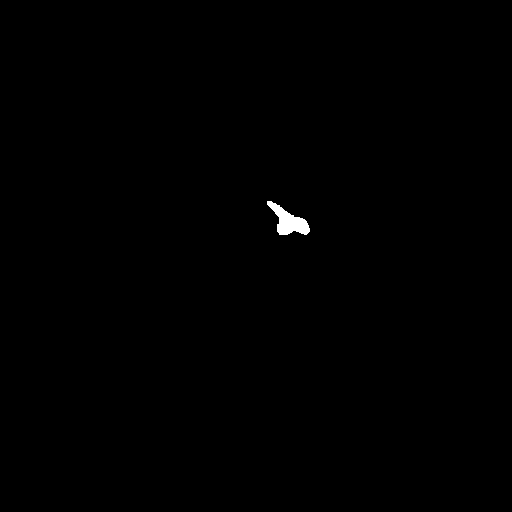

In [20]:
lab_prompt_png

### Define Image Processor inputs

In [21]:
## With PNG 
inputs = image_processor(
    #images=img_prompt_png,  # sanity check
    images=img_png,
    prompt_images=img_prompt_png,
    prompt_masks=lab_prompt_png, 
    num_labels=numlabels,
    return_tensors="pt",
    do_rescale=False,
    #image_mean=[0., 0., 0.],
    #image_std=[1., 1., 1.],
    do_convert_rgb=False,
)

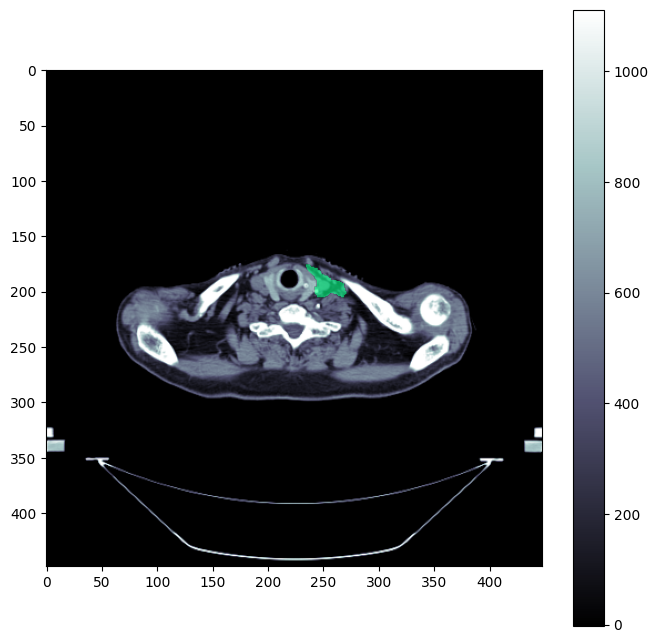

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = inputs['prompt_pixel_values'][0,0,...]
nplab = inputs['prompt_masks'][0,0,...]
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax.imshow(npimg, cmap='bone')
ax.imshow(np.ma.masked_where(nplab < 0.5, 
                             nplab), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

### Get model outputs

In [23]:
with torch.no_grad():
    outputs = model(**inputs)


In [24]:
outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

In [25]:
import copy

In [26]:
new_outputs = copy.deepcopy(outputs)
new_outputs['pred_masks'] = outputs['pred_masks'][-1,...].unsqueeze(dim=0)

In [27]:
new_outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

In [28]:
target_sizes = [(img.shape[2],img.shape[1])]
mask = image_processor.post_process_semantic_segmentation(new_outputs, (448,448), num_labels=numlabels)[0]

In [29]:
mask.min(), mask.max()

(tensor(0), tensor(1))

In [30]:
outputs['pred_masks'].min(), outputs['pred_masks'].max()

(tensor(-2.1982), tensor(3.0407))

In [31]:
outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

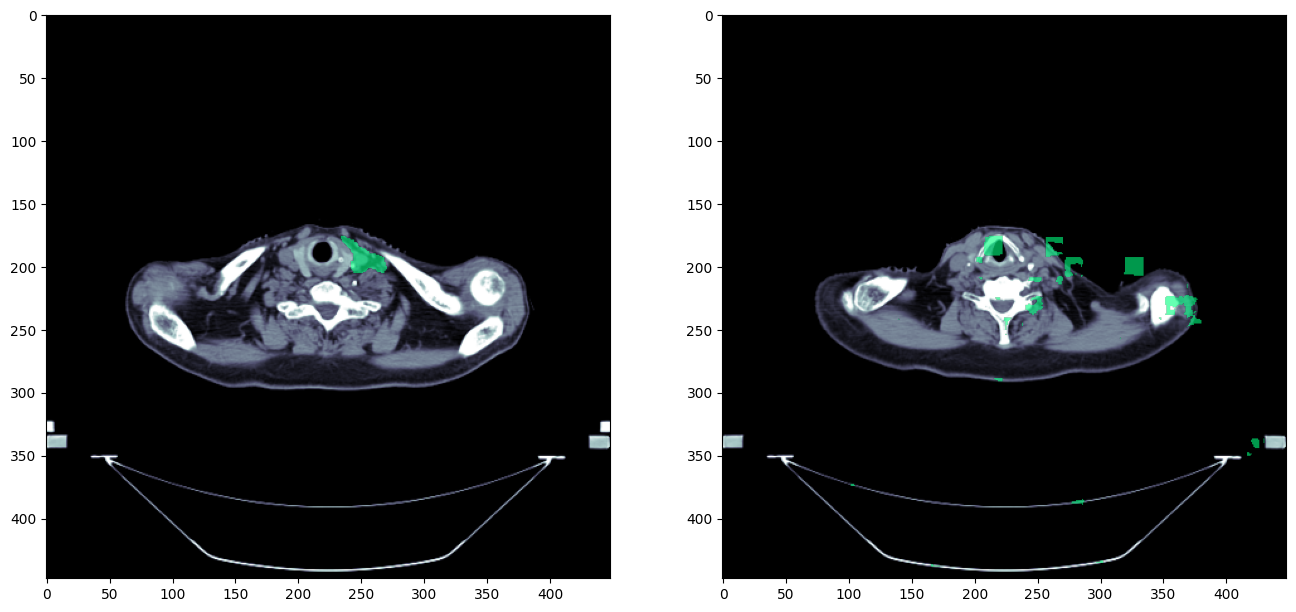

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

npimg_prompt = inputs['prompt_pixel_values'][0,0,...].detach().clone().numpy()
nplab = inputs['prompt_masks'][0,0,...].detach().clone().numpy()
npimg = inputs['pixel_values'][0,0,...].detach().clone().numpy()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax[0].imshow(npimg_prompt, cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab < 0.5, 
                             nplab), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

ctplot = ax[1].imshow(npimg, cmap='bone')
ax[1].imshow(np.ma.masked_where(mask < 0.5, 
                             mask), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

#fig.colorbar(ctplot)